In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

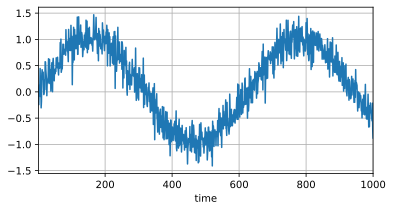

In [2]:
T=1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
d2l.plot(time,x,'time',xlim=[1,1000],figsize=(6,3))

In [3]:
tau=4
features=torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i]=x[i:i+T-tau]
labels=x[tau:].reshape((-1,1))
#n_train为用于训练的样本的数量
batch_size,n_train=16,660

train_iter=d2l.load_array((features[:n_train],labels[:n_train]),
                          batch_size=batch_size,is_train=True)


In [4]:
def init_weigths(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net=nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    net.apply(init_weigths)

    return net

loss=nn.MSELoss(reduction='none')

In [7]:
def train(net,train_iter,learning_rate,num_epochs,loss):
    trainer=torch.optim.Adam(net.parameters(),lr=learning_rate)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            pred=net(X)
            ls=loss(pred,y)
            ls.sum().backward()
            trainer.step()
        print(f"epoch{epoch+1},loss:{d2l.evaluate_loss(net,train_iter,loss):f}")

net=get_net()
train(net,train_iter,0.01,5,loss)

epoch1,loss:0.063504
epoch2,loss:0.061090
epoch3,loss:0.058162
epoch4,loss:0.054375
epoch5,loss:0.055614


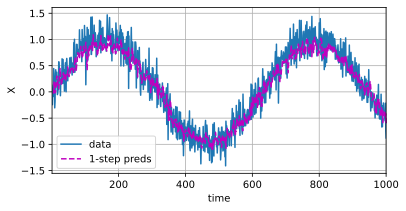

In [8]:
#本质是已经有了所有数据，用已有的tau个数据预测下一个数据，在预测时只会利用已有的数据，不会利用前面的预测数据
onestep_preds=net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],
         'time','X',legend=['data','1-step preds'],xlim=[1,1000],
         figsize=(6,3))

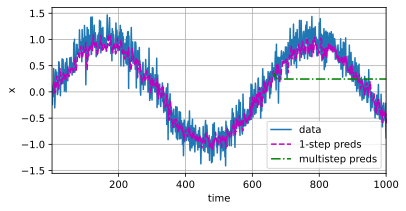

In [9]:
#只有前面n_train个数据，但在做预测的时候需要预测点前面tau个数据，所以在超出n_train+tau后需要利用预测的数据来进行下一步预测
multistep_preds=torch.zeros(T)
multistep_preds[:n_train+tau]=x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i]=net(multistep_preds[i-tau:i].reshape((1,-1)))

d2l.plot([time,time[tau:],time[n_train+tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy(),multistep_preds[n_train+tau:].detach().numpy()],
         'time','x',legend=['data','1-step preds','multistep preds'],
         xlim=[1,1000],figsize=(6,3))

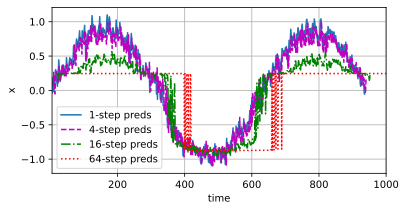

In [12]:
max_steps=64

features=torch.zeros((T-tau-max_steps+1,tau+max_steps))

for i in range(tau):
    features[:,i]=x[i:i+T-tau-max_steps+1]

for i in range(tau,tau+max_steps):
    features[:,i]=net(features[:,i-tau:i]).reshape(-1)

steps=(1,4,16,64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))